# IY011 Baseline Model Training

Imrprovement from the ``IY011_contrastive_learning_model_training_1.ipynb``:
- File splitting and selection first

In [22]:
from pathlib import Path
import numpy as np
import pandas as pd
# plotting 
import matplotlib.pyplot as plt
# ml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from models.transformer import TransformerClassifier
from training.eval import evaluate_model
from training.train import train_model 

# data handling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.data_loader import baseline_data_prep, BaselineDataset, save_loader_to_disk, load_loader_from_disk

import wandb
%load_ext autoreload
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
script_dir = Path.cwd()
DATA_ROOT = script_dir / "data_cv_variation"
RESULTS_PATH = DATA_ROOT / "IY011_simulation_cv_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
# filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
df_params = df_params[(df_params['success'] == True) & 
                      (df_params['error_message'].isna()) &
                      (df_params['mean_rel_error_pct'] < 10) & 
                      (df_params['cv_rel_error_pct'] < 10) & 
                      (df_params['t_ac_rel_error_pct'] < 10)]
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]

# extract meta data
parameter_sets = [{
    'sigma_b': row['sigma_b'],
    'sigma_u': row['sigma_u'],
    'rho': row['rho'],
    'd': row['d'],
    'label': 0
} for idx, row in df_params.iterrows()]
time_points = np.arange(0, 3000, 1.0)
size = 1000

In [3]:
# === Dataloader hyperparams & data prep ===
batch_size = 64
num_groups_train=200
num_groups_val=int(num_groups_train * 0.2)
num_groups_test=int(num_groups_train * 0.2)
num_traj=2
# === Dataloader hyperparams & data prep ===

In [4]:
# === Data Preparation ===
train_loader, val_loader, test_loader, scaler = baseline_data_prep(
    TRAJ_NPZ_PATH,
    batch_size=batch_size,
    num_groups_train=num_groups_train,
    num_groups_val=num_groups_val,
    num_groups_test=num_groups_test,
    num_traj=num_traj,
)
# === Data Preparation ===

Files split: 535 Train, 134 Val, 168 Test
Generating 200 training groups...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:09<00:00, 20.82it/s]


Generating validation groups...


100%|██████████| 40/40 [00:01<00:00, 23.77it/s]


Generating test groups...


100%|██████████| 40/40 [00:01<00:00, 22.29it/s]

Batch Mean (should be ~0): 0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -11.98, Max Value: 13.74


In [ ]:
# === Save data for debugging later === 
# # 1. Define paths
# train_save_path = DATA_ROOT / "TEST-static_train.pt"
# val_save_path   = DATA_ROOT / "TEST-static_val.pt"
# test_save_path  = DATA_ROOT / "TEST-static_test.pt"

# # 2. Check if static data already exists
# if not train_save_path.exists():
#     print("Static data not found. Saving...")
    
#     # Save them to disk
#     save_loader_to_disk(train_loader, train_save_path)
#     save_loader_to_disk(val_loader, val_save_path)
#     save_loader_to_disk(test_loader, test_save_path)
# else:
#     print("Found existing static data on disk, the simulated data will not be saved, to prevent overwriting existing data.")
# === Save data for debugging later === 

Static data not found. Saving...
❄️  Freezing and saving loader to /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data_cv_variation/TEST-static_train.pt...


Materializing Data: 100%|██████████| 4/4 [00:00<00:00, 304.71it/s]


✅ Saved 200 samples to /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data_cv_variation/TEST-static_train.pt
❄️  Freezing and saving loader to /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data_cv_variation/TEST-static_val.pt...


Materializing Data: 100%|██████████| 1/1 [00:00<00:00, 341.61it/s]


✅ Saved 40 samples to /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data_cv_variation/TEST-static_val.pt
❄️  Freezing and saving loader to /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data_cv_variation/TEST-static_test.pt...


Materializing Data: 100%|██████████| 1/1 [00:00<00:00, 306.87it/s]

✅ Saved 40 samples to /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data_cv_variation/TEST-static_test.pt


In [ ]:
# 3. Load the Static Loaders 
# Note: You can change batch_size here freely!
# train_loader = load_loader_from_disk(train_save_path, batch_size=64, shuffle=True)
# val_loader   = load_loader_from_disk(val_save_path,   batch_size=64, shuffle=False)
# test_loader  = load_loader_from_disk(test_save_path,  batch_size=64, shuffle=False)

# X_b, y_b = next(iter(train_loader))
# print(X_b.shape, y_b.shape) # (Batch, Seq_Len * num_traj, 1), (Batch, 1)

torch.Size([64, 5003, 1]) torch.Size([64, 1])


## Visualise Data and Check Shapes

In [29]:
X_b, y_b = next(iter(train_loader))
print(X_b.shape, y_b.shape) # (Batch, Seq_Len * num_traj, 1), (Batch, 1)

torch.Size([64, 5003, 1]) torch.Size([64, 1])


Batch Summary - Batch Size: 64
  Total Sequence Length (T): 5003 | Segment Length (L): 2501
  Positive Samples (Label 1): 28
  Negative Samples (Label 0): 36


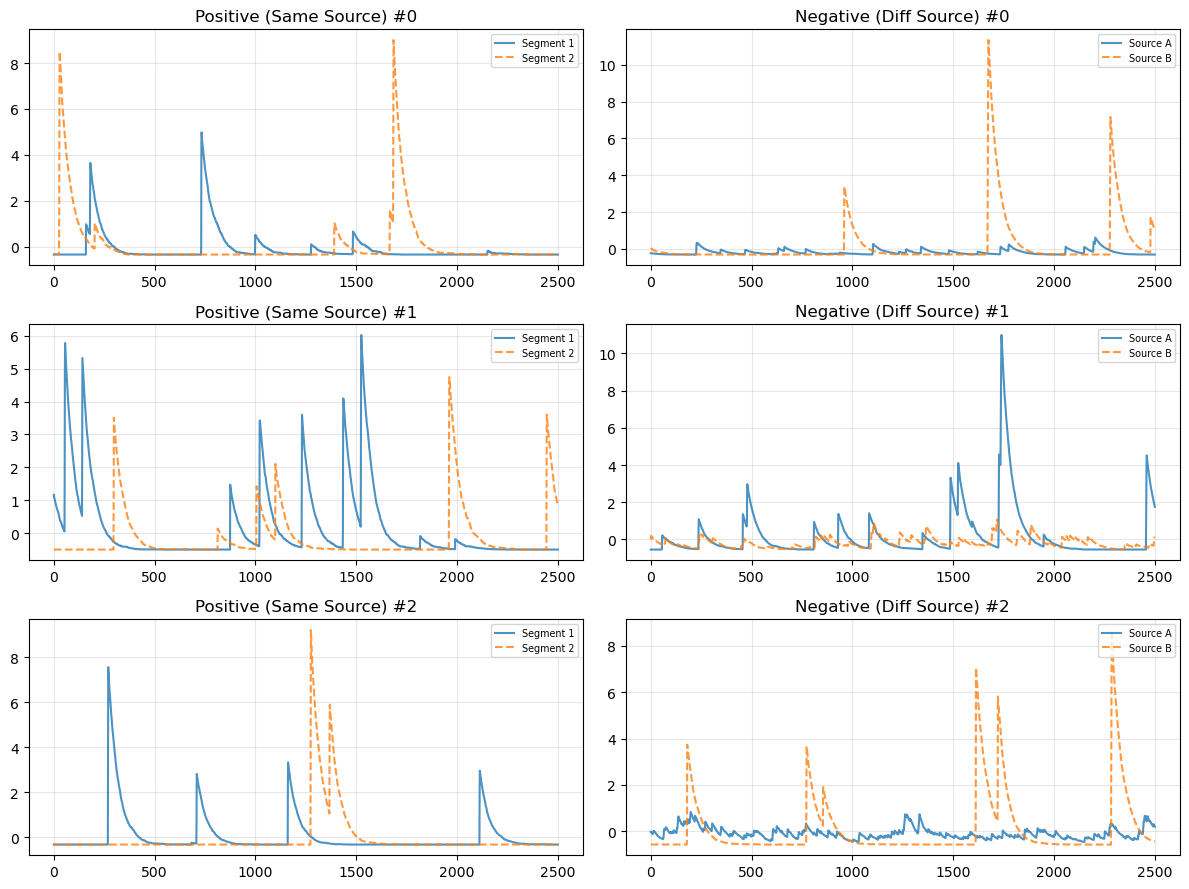

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_loader_pairs(loader, num_traj=2, sep_len=5, num_to_plot=3):
    """
    Visualizes Positive and Negative inputs from the DataLoader.
    Handles CONCATENATED time series (Batch, Total_Time, 1).
    Splits the time dimension back into segments for overlay plotting.
    """
    # 1. Get a single batch
    try:
        batch = next(iter(loader))
    except StopIteration:
        print("Loader is empty.")
        return

    X_tensor, y_tensor = batch
    
    # X shape: (Batch, Total_Time, 1)
    # y shape: (Batch, 1)
    
    # Move to CPU/Numpy
    X = X_tensor.cpu().numpy()
    y = y_tensor.cpu().numpy().flatten()
    
    B, T, C = X.shape
    
    # 2. Calculate Segment Length (L) to de-concatenate
    # Formula: T = num_traj * L + (num_traj - 1) * sep_len
    if num_traj > 1:
        total_sep_space = (num_traj - 1) * sep_len
        remaining_space = T - total_sep_space
        L = remaining_space // num_traj
    else:
        L = T # Should not happen for pairs, but safe fallback
        
    print(f"Batch Summary - Batch Size: {B}")
    print(f"  Total Sequence Length (T): {T} | Segment Length (L): {L}")
    print(f"  Positive Samples (Label 1): {np.sum(y==1)}")
    print(f"  Negative Samples (Label 0): {np.sum(y==0)}")

    # 3. Separate Indices by Label
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    # 4. Plotting Setup
    # We create a grid: Left Column = Positives, Right Column = Negatives
    fig, axes = plt.subplots(num_to_plot, 2, figsize=(12, 3 * num_to_plot))
    if num_to_plot == 1: axes = axes.reshape(1, -1)
    
    # --- Helper to extract a specific segment from the concatenated sequence ---
    def get_segment(sample_idx, segment_rank):
        # segment_rank: 0 for 1st traj, 1 for 2nd traj, etc.
        start = segment_rank * (L + sep_len)
        end = start + L
        return X[sample_idx, start:end, 0] # Extract the signal

    # --- Plot Positives (Left Column) ---
    for i in range(num_to_plot):
        ax = axes[i, 0]
        if i < len(pos_indices):
            idx = pos_indices[i]
            
            # Extract Trajectory 1 and Trajectory 2
            traj_1 = get_segment(idx, 0)
            traj_2 = get_segment(idx, 1) # Assumes num_traj >= 2
            
            # Plot overlaid to show they look similar (Same Source)
            ax.plot(traj_1, label='Segment 1', alpha=0.8, linewidth=1.5)
            ax.plot(traj_2, label='Segment 2', alpha=0.8, linestyle='--', linewidth=1.5)
            
            ax.set_title(f"Positive (Same Source) #{i}")
            ax.legend(loc='upper right', fontsize='x-small')
        ax.grid(True, alpha=0.3)

    # --- Plot Negatives (Right Column) ---
    for i in range(num_to_plot):
        ax = axes[i, 1]
        if i < len(neg_indices):
            idx = neg_indices[i]
            
            # For Negative samples, Segments are from DIFFERENT files.
            # Usually: Segments 0-(N/2) are File A, Segments (N/2)-N are File B.
            
            # We compare the FIRST segment (Source A) vs the LAST segment (Source B)
            # This ensures we are comparing the two different sources.
            traj_a = get_segment(idx, 0) 
            traj_b = get_segment(idx, num_traj - 1) 
            
            ax.plot(traj_a, label='Source A', alpha=0.8, linewidth=1.5)
            ax.plot(traj_b, label='Source B', alpha=0.8, linestyle='--', linewidth=1.5)
            
            ax.set_title(f"Negative (Diff Source) #{i}")
            ax.legend(loc='upper right', fontsize='x-small')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# === Usage ===
visualize_loader_pairs(train_loader, num_traj=num_traj, sep_len=1, num_to_plot=3)

In [10]:
# === Model hyperparams ===
input_size = 1
num_classes = 2
d_model=64
nhead=4
num_layers=2
dropout=0.001
use_conv1d=False 

model = TransformerClassifier(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout, 
    use_conv1d=use_conv1d 
)
# === Model hyperparams ===

# === Training hyperparams ===
epochs = 50
patience = 10
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

### schedulers ### 
# 1. simple scheduler choice
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
# total_steps = epochs * len(train_loader)
# warmup_steps = int(0.1 * total_steps)   # 10% warmup (good default)
# from transformers import get_cosine_schedule_with_warmup
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=total_steps,
# ) 

loss_fn = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = 1.0
save_path = None
verbose = True

model.to(device)
# === Training hyperparams ===

TransformerClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (pe): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.001, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.001, inplace=False)
        (dropout2): Dropout(p=0.001, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.001, inplace=False)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

In [11]:
# === wandb config (required for tracking within train_model) ===
wandb_config = {
    "entity": "grignard-reagent",
    "project": "IY011-baseline-model",
    "name": f"num_groups_train_{num_groups_train}_traj_{num_traj}_batch_size_{batch_size} (cv variation)", # change this to what you want
    "dataset": DATA_ROOT.name,
    "batch_size": batch_size,
    "input_size": input_size,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "num_classes": num_classes,
    "dropout": dropout,
    "use_conv1d": use_conv1d,
    "epochs": epochs,
    "patience": patience,
    "lr": lr,
    "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__,
    "loss_fn": type(loss_fn).__name__,
    "model": type(model).__name__,
    "batch_size": train_loader.batch_size,
    "num_traj_per_group": num_traj,
    "num_groups_train": num_groups_train,
    "num_groups_val": num_groups_val,
    "num_groups_test": num_groups_test,
}
# === wandb config === 

In [30]:
from training.train import train_model
history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    patience=patience,
    lr=lr,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    grad_clip=grad_clip,
    save_path=save_path,
    verbose=verbose,
    # wandb_logging=True, # this enables wandb logging within train_model
    # wandb_config=wandb_config, # pass the config dictionary
)

Starting training...
Epoch [1/50] | train_loss 0.2666 | train_acc 0.9000 | val_loss 0.3268 | val_acc 0.8500
No improvement (1/10).
Epoch [2/50] | train_loss 0.2598 | train_acc 0.8950 | val_loss 0.3261 | val_acc 0.8500
No improvement (2/10).
Epoch [3/50] | train_loss 0.2580 | train_acc 0.8950 | val_loss 0.3296 | val_acc 0.8500
No improvement (3/10).
Epoch [4/50] | train_loss 0.2517 | train_acc 0.8950 | val_loss 0.3345 | val_acc 0.8500
No improvement (4/10).
Epoch [5/50] | train_loss 0.2513 | train_acc 0.8900 | val_loss 0.3364 | val_acc 0.8500
No improvement (5/10).
Epoch [6/50] | train_loss 0.2484 | train_acc 0.8950 | val_loss 0.3347 | val_acc 0.8500
No improvement (6/10).
Epoch [7/50] | train_loss 0.2459 | train_acc 0.8950 | val_loss 0.3344 | val_acc 0.8500
No improvement (7/10).
Epoch [8/50] | train_loss 0.2448 | train_acc 0.8950 | val_loss 0.3352 | val_acc 0.8500
No improvement (8/10).
Epoch [9/50] | train_loss 0.2445 | train_acc 0.8950 | val_loss 0.3352 | val_acc 0.8500
No improveme

## Save Model

In [9]:
# save the trained model
# model_path = 'IY011_baseline_transformer_model.pth'
# torch.save(model.state_dict(), model_path)

## Eval: test_loader

In [13]:
# evaluate on test set
test_loss, test_acc = evaluate_model(
    model,
    test_loader,
    loss_fn,
    device,
)

Test — loss: 0.73 | acc: 0.72


## SVM Benchmark

In [14]:
def extract_data_for_svm(loader):
    """
    Extracts all batches from a DataLoader and flattens them for SVM input.
    Input X: (Batch, Time, Features) -> Output X: (Total_Samples, Time * Features)
    """
    X_list = []
    y_list = []
    
    print(f"Extracting data from loader for SVM...")
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            # Move to CPU and convert to numpy
            X_np = X_batch.cpu().numpy()
            y_np = y_batch.cpu().numpy()
            
            # Flatten the time series: 
            # (Batch, Seq_Len, 1) -> (Batch, Seq_Len)
            # This turns the time series into a long feature vector
            X_flat = X_np.reshape(X_np.shape[0], -1)
            
            X_list.append(X_flat)
            y_list.append(y_np)
            
    # Concatenate all batches
    return np.vstack(X_list), np.concatenate(y_list)

In [15]:
from classifiers.svm_classifier import svm_classifier

# 1. Extract Data dynamically from your loaders
X_train_svm, y_train_svm = extract_data_for_svm(train_loader)
X_test_svm, y_test_svm   = extract_data_for_svm(test_loader)

print(f"SVM Train Shape: {X_train_svm.shape}")
print(f"SVM Test Shape:  {X_test_svm.shape}")

# 2. Run the SVM Classifier
svm_accuracy = svm_classifier(
    X_train_svm,
    X_test_svm,
    y_train_svm,
    y_test_svm,
)

Extracting data from loader for SVM...
Extracting data from loader for SVM...
SVM Train Shape: (200, 5003)
SVM Test Shape:  (40, 5003)
=== SVM (RBF Kernel) Classification Accuracy: 0.53 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Permutation Test

In [16]:
def run_permutation_test(model, test_loader, device='cpu', sep_len=1, num_traj=2):
    """
    Evaluates the model on:
    1. Original Data (Preserves Temporal Patterns)
    2. Shuffled Data (Destroys Temporal Patterns, Preserves Stats & Structure)
    
    Generalized to handle any num_traj (2, 4, etc.).
    """
    model.eval()
    model.to(device)
    
    correct_original = 0
    correct_shuffled = 0
    total = 0
    
    print(f"Running Permutation Test (num_traj={num_traj}, sep_len={sep_len})...")
    
    with torch.no_grad():
        for X, y in test_loader:
            # Move to device
            X = X.to(device)
            y = y.to(device).squeeze() 
            
            # --- Helper to get predictions ---
            def get_preds(logits):
                if logits.shape[1] > 1:
                    return torch.argmax(logits, dim=1)
                else:
                    return (torch.sigmoid(logits) > 0.5).float().squeeze()

            # --- 1. Test on ORIGINAL (Ordered) ---
            logits_orig = model(X)
            preds_orig = get_preds(logits_orig)
            correct_original += (preds_orig == y).sum().item()
            
            # --- 2. Test on SHUFFLED (Structure Preserved) ---
            X_shuffled = X.clone()
            B, T, C = X.shape
            
            # Logic to determine Segment Length (L) for any num_traj
            # T = (num_traj * L) + ((num_traj - 1) * sep_len)
            
            if num_traj > 1:
                total_sep_space = (num_traj - 1) * sep_len
                remaining_space = T - total_sep_space
                L = remaining_space // num_traj
                
                # Validation: Check if the math adds up perfectly
                if L * num_traj + total_sep_space != T:
                    print(f"⚠️ Warning: Dimension mismatch! T={T} doesn't fit num_traj={num_traj}, sep={sep_len}. Shuffling globally.")
                    # Fallback: Global Shuffle
                    for i in range(B):
                        idx = torch.randperm(T)
                        X_shuffled[i] = X[i, idx, :]
                else:
                    # Component-wise Shuffle Loop
                    for i in range(B):
                        current_pos = 0
                        for k in range(num_traj):
                            # Define start and end of the k-th trajectory segment
                            seg_start = current_pos
                            seg_end = current_pos + L
                            
                            # Shuffle this specific segment
                            idx_segment = torch.randperm(L)
                            X_shuffled[i, seg_start:seg_end, :] = X[i, seg_start:seg_end, :][idx_segment]
                            
                            # Move pointer: Skip the segment we just shuffled + the separator
                            current_pos = seg_end + sep_len
            else:
                # num_traj=1 case (Simple global shuffle)
                for i in range(B):
                    idx = torch.randperm(T)
                    X_shuffled[i] = X[i, idx, :]
            
            logits_shuff = model(X_shuffled)
            preds_shuff = get_preds(logits_shuff)
            correct_shuffled += (preds_shuff == y).sum().item()
            
            total += B
    
    # Calculate Final Accuracy
    acc_orig = correct_original / total
    acc_shuff = correct_shuffled / total
    
    print(f"------------------------------------------------")
    print(f"Accuracy on ORIGINAL Data:  {acc_orig:.2%}")
    print(f"Accuracy on SHUFFLED Data:  {acc_shuff:.2%} (Structure Preserved)")
    print(f"------------------------------------------------")
    
    return acc_orig, acc_shuff

print("\n=== Running Permutation Test ===")
acc_orig, acc_shuff = run_permutation_test(model, test_loader, device=device)


=== Running Permutation Test ===
Running Permutation Test (num_traj=2, sep_len=1)...


------------------------------------------------
Accuracy on ORIGINAL Data:  70.00%
Accuracy on SHUFFLED Data:  85.00% (Structure Preserved)
------------------------------------------------


Visualizing Permutation Logic (num_traj=2, sep_len=1)...
Sequence Length (T): 5003 | Segment Length (L): 2501


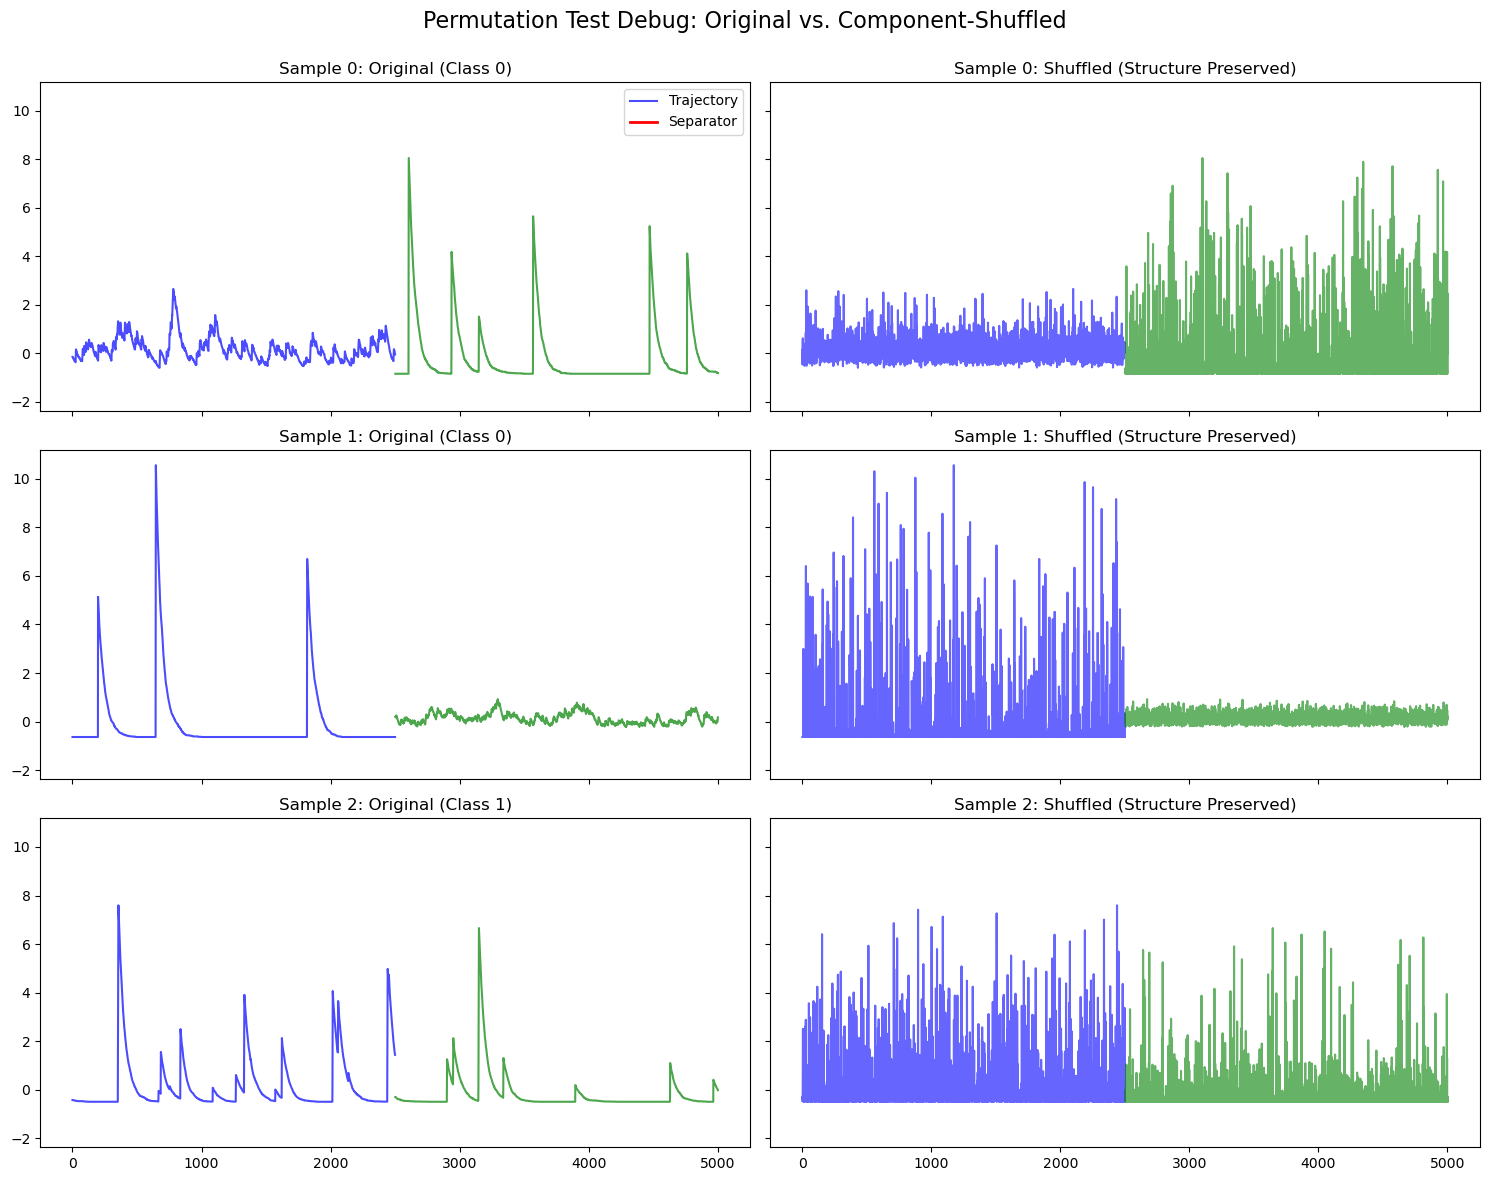

In [ ]:
def visualize_permutation_debug(loader, num_traj=2, sep_len=1, num_samples=2):
    """
    Visualizes original vs. shuffled trajectories to debug the permutation logic.
    - Separators are highlighted in RED (should NOT change).
    - Trajectories are highlighted in BLUE/GREEN (should look scrambled).
    """
    print(f"Visualizing Permutation Logic (num_traj={num_traj}, sep_len={sep_len})...")
    
    # 1. Fetch a Batch
    X, y = next(iter(loader))
    B, T, C = X.shape
    
    # 2. Calculate Segment Length (L)
    # T = (num_traj * L) + ((num_traj - 1) * sep_len)
    if num_traj > 1:
        total_sep_space = (num_traj - 1) * sep_len
        remaining_space = T - total_sep_space
        L = remaining_space // num_traj
    else:
        L = T # No separators
    
    print(f"Sequence Length (T): {T} | Segment Length (L): {L}")

    # 3. Create Shuffled Copy (using the exact logic from run_permutation_test)
    X_shuffled = X.clone()
    
    if num_traj > 1:
        # Check math
        if L * num_traj + total_sep_space != T:
            print(f"❌ Error: Dimension mismatch! T={T} != {num_traj}*{L} + {num_traj-1}*{sep_len}")
            return

        # Perform Shuffle
        for i in range(B):
            current_pos = 0
            for k in range(num_traj):
                seg_start = current_pos
                seg_end = current_pos + L
                
                # Shuffle ONLY the segment
                idx_segment = torch.randperm(L)
                X_shuffled[i, seg_start:seg_end, :] = X[i, seg_start:seg_end, :][idx_segment]
                
                # Move past segment + separator
                current_pos = seg_end + sep_len

    # 4. Plot Results
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 4 * num_samples), sharex=True, sharey=True)
    if num_samples == 1: axes = axes.reshape(1, -1)
    
    fig.suptitle("Permutation Test Debug: Original vs. Component-Shuffled", fontsize=16)

    for i in range(num_samples):
        # --- Plot Original ---
        ax_orig = axes[i, 0]
        ax_orig.set_title(f"Sample {i}: Original (Class {y[i].item():.0f})")
        
        # Plot Segments and Separators with different colors
        curr = 0
        for k in range(num_traj):
            # Plot Segment (Blue/Green alternating)
            color = 'blue' if k % 2 == 0 else 'green'
            seg_data = X[i, curr : curr+L, 0].numpy()
            x_range = np.arange(curr, curr+L)
            ax_orig.plot(x_range, seg_data, color=color, alpha=0.7, label="Trajectory" if k==0 else "")
            
            # Plot Separator (Red)
            if k < num_traj - 1:
                sep_start = curr + L
                sep_end = sep_start + sep_len
                sep_data = X[i, sep_start : sep_end, 0].numpy()
                x_range_sep = np.arange(sep_start, sep_end)
                ax_orig.plot(x_range_sep, sep_data, color='red', linewidth=2, label="Separator" if k==0 else "")
                
                curr = sep_end
            else:
                curr += L
        
        # --- Plot Shuffled ---
        ax_shuf = axes[i, 1]
        ax_shuf.set_title(f"Sample {i}: Shuffled (Structure Preserved)")
        
        curr = 0
        for k in range(num_traj):
            # Plot Segment
            color = 'blue' if k % 2 == 0 else 'green'
            seg_data = X_shuffled[i, curr : curr+L, 0].numpy()
            x_range = np.arange(curr, curr+L)
            ax_shuf.plot(x_range, seg_data, color=color, alpha=0.6)
            
            # Plot Separator
            if k < num_traj - 1:
                sep_start = curr + L
                sep_end = sep_start + sep_len
                sep_data = X_shuffled[i, sep_start : sep_end, 0].numpy()
                x_range_sep = np.arange(sep_start, sep_end)
                ax_shuf.plot(x_range_sep, sep_data, color='red', linewidth=2)
                
                curr = sep_end
            else:
                curr += L

        if i == 0: ax_orig.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# === USAGE ===
visualize_permutation_debug(test_loader, num_traj=2, sep_len=1, num_samples=3)

(After changing from global-scaling to instance normalisation) Issues:
1. Overfitting during training
2. Transformer model relying too much on static features rather than temporal dynamics

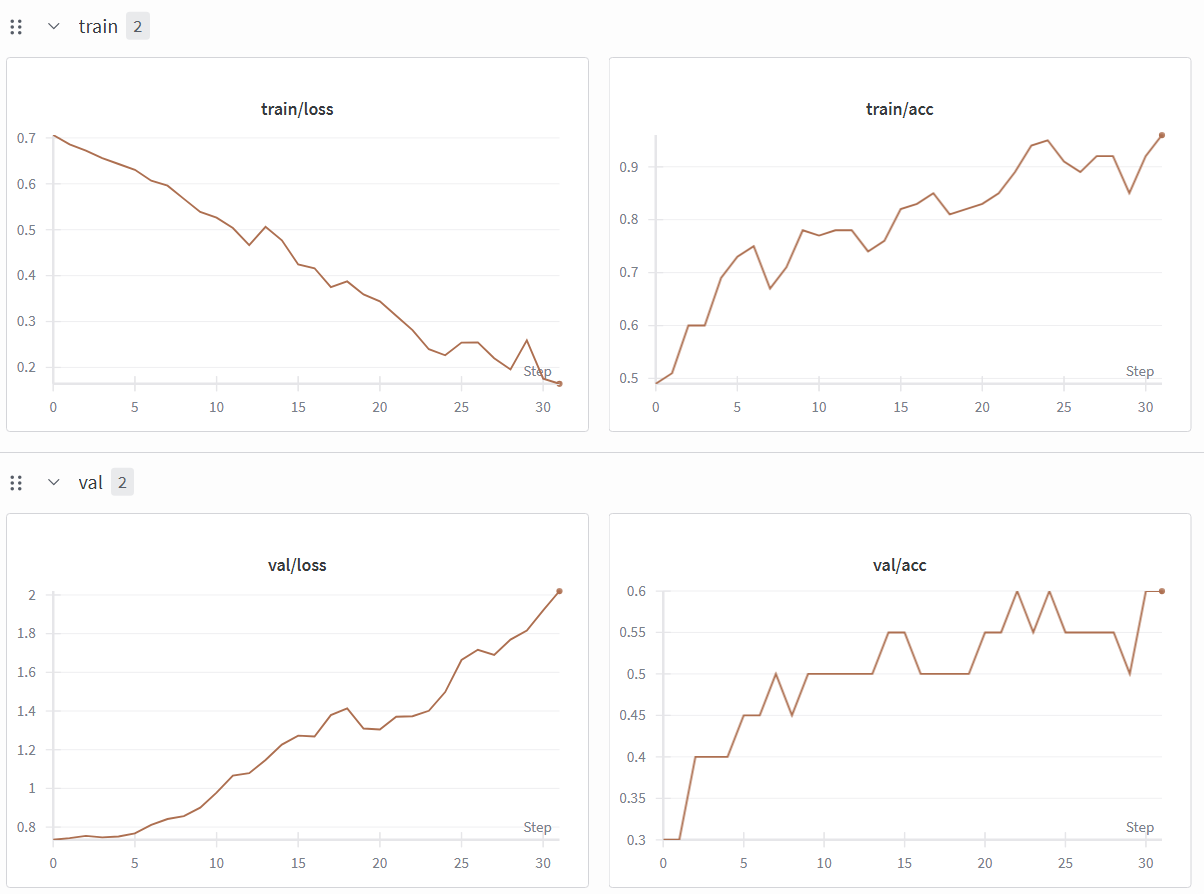